# Milestone 3: Finetune the model with sidewalks dataset

First, please manually copy the extracted sidewalks data to the current folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os, tarfile, sys
from pathlib import Path
from transformers import SamProcessor, SamModel, SamConfig

from tqdm import tqdm
from statistics import mean

import torch
from torch.optim import Adam
from torch.utils.data import IterableDataset, DataLoader

import monai
import cv2

# paths, feel free to change it to suit your needs
dataset_path = Path().absolute()
test_label_path = dataset_path.joinpath("Label", "Test")
test_images_path = dataset_path.joinpath("Test")
train_label_path = dataset_path.joinpath("Label", "Train")
train_images_path = dataset_path.joinpath("Train")

# for extracting tar in hpc
dataset_path = Path().absolute().joinpath("shared", "mldatasets", "sidewalks")

/home/shing6444/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-04-16 07:58:50.794982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 07:58:53.032511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Wrap the dataset into a class as described by the example

In [2]:
# skip ahead when continuing from previous checkpoints, you can check where did the last session left off at ckpt_batch_nums.txt
batch_num_continue = 0  # used for continuing from checkpoint, please set it manually


def read_dir(path):
    '''to read files from local file system on the path, used initially when I was training the model in my local machine'''
    batch = 0
    continued = False

    for file_name in os.listdir(str(path)):
        if file_name.endswith(".tfw") or file_name == "yolact":
            continue

        batch += 1
        if batch < batch_num_continue: # skip ahead when continuing from checkpoint
            continue
        if not continued:
            print(f"output restarted at batch number {batch}")
        continued = True

        image = tifffile.imread(str(path.joinpath(file_name)))
        yield image


def read_tar(tar, directory):
    '''generator to read image in the specified directory in the provided tarfile object'''
    batch = 0
    continued = False
    for file in tar:
        if file.path.startswith(directory):
            file_name = file.path.split("/")[-1]
            if file_name.endswith(".tfw") or file_name == "yolact":
                continue

            batch += 1
            if batch < batch_num_continue: # skip ahead when continuing from checkpoint
                continue
            if not continued:
                print(f"output restarted at batch number {batch}")
            continued = True

            c = tar.extractfile(file).read()
            na = np.frombuffer(c, dtype=np.uint8)
            im = cv2.imdecode(na, cv2.IMREAD_COLOR)
            yield im


#Get bounding boxes from mask. copied from tutorial
def get_bounding_box(ground_truth_map):
    # get bounding box from mask, get minimum and maximum x and y
    ground_truth_map = cv2.cvtColor(ground_truth_map, cv2.COLOR_BGR2GRAY)  # hpc
    y_indices, x_indices = np.where(ground_truth_map > 0)
    H, W = ground_truth_map.shape

    if y_indices.size == 0 or x_indices.size == 0:  # randomly generate bbox
        x = np.random.randint(0, W - 20)
        y = np.random.randint(0, H - 20)
        w = np.random.randint(20, W - x)
        h = np.random.randint(20, H - y)
        return [x, y, x + w, y + h]

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox


class SAMDataset(IterableDataset):
    """ copied from tutorial!
    We need to use generators instead of naively storing all data in memory due to the sheer size of the training data.
    """

    def __init__(self, path_x, path_y, processor, is_tar=False, dirx=None, diry=None):  # x: input, y: label
        self.processor = processor
        if is_tar:  # read tar, path=path to tar file; dirx, diry=folders to read inside the tar file
            self.generator_x = read_tar(tarfile.open(str(path_x), "r:*"), dirx)
            self.generator_y = read_tar(tarfile.open(str(path_y), "r:*"), diry)
        else:
            self.generator_x = read_dir(path_x)
            self.generator_y = read_dir(path_y)

    def __iter__(self): # copied from tutorial
        for image, ground_truth_mask in zip(self.generator_x, self.generator_y):
            # get bounding box prompt
            prompt = get_bounding_box(ground_truth_mask)
            # prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
            # remove batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            # add ground truth segmentation
            inputs["ground_truth_mask"] = ground_truth_mask
            yield inputs

In [3]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")  # preprocess
model = SamModel.from_pretrained("facebook/sam-vit-huge", )
# uncommment when local
# trainset = SAMDataset(train_images_path, train_label_path, processor)
# testset = SAMDataset(test_images_path, test_label_path, processor)

# uncomment when HPC
trainset = SAMDataset(str(dataset_path.joinpath("train.tar")), str(dataset_path.joinpath("label.tar")), processor, True,
                      "Train/", "Label/Train/")
testset = SAMDataset(str(dataset_path.joinpath("val.tar")), str(dataset_path.joinpath("label.tar")), processor, True,
                     "Test/", "Label/Test/")

BATCH_SIZE = 2

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [ ]:
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# Use dice CE loss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

#Training loop
num_epochs = 1

# for continuing for checkpoint
# model.load_state_dict(torch.load("sidewalks-sam-backup.pt"))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    batch_num = 0
    batch_trained = 0
    for batch in tqdm(trainloader):
        batch_num += 1
        # sample only 1/5, approximately 36000 images as training all of them takes too long. should take about 20 hours on HPC
        if np.random.randint(5) != 0:
            continue

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=True)

        # compute loss
        predicted_masks = torch.sigmoid(outputs.pred_masks.squeeze(1))  # need sigmoid to present it as probability map
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)  # for hpc

        loss = seg_loss(predicted_masks, # add dimension to gt masks so that dimensions of gt and pred masks matches
                        torch.reshape(ground_truth_masks, (BATCH_SIZE, 3, 256, 256)))  

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        # save model for backup every 250 batches trained. rounds up to about 15 minutes on HPC
        if batch_trained % 250 == 0:
            torch.save(model.state_dict(), 'sidewalks-sam-backup.pt')
            with open("ckpt_batch_nums.txt", "w") as f:
                f.write(str(batch_num))
        batch_trained += 1

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

torch.save(model.state_dict(), 'sidewalks-sam.pt')

Test inference

In [4]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

sidewalk_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
sidewalk_model.load_state_dict(torch.load("sidewalks-sam.pt"))

sidewalk_model.to("cuda")


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

Plot a sample test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


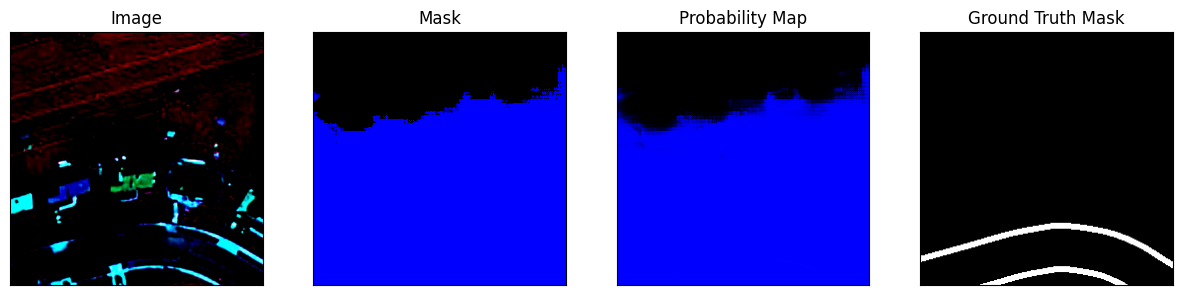

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [1]:
indices = [6, 5, 1]  # put desired images to show in descending order here
device = "cuda"
testset = SAMDataset(str(dataset_path.joinpath("val.tar")), str(dataset_path.joinpath("label.tar")), processor, True,
                     "Test/", "Label/Test/")
testloader = DataLoader(testset, batch_size=1)


def plot_batch(selected_batch):
    sidewalk_model.eval()

    # forward pass
    with torch.no_grad():
        outputs = sidewalk_model(pixel_values=selected_batch["pixel_values"].to(device),
                                 input_boxes=selected_batch["input_boxes"].to(device),
                                 multimask_output=True)

    # apply sigmoid
    seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    seg_prob = seg_prob.cpu().numpy().squeeze()
    seg = (seg_prob > 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.squeeze(np.array(selected_batch["pixel_values"])).transpose(1, 2, 0))
    axes[0].set_title("Image")

    # Plot the second image on the right
    axes[1].imshow(seg.transpose(1, 2, 0).astype(float))
    axes[1].set_title("Mask")

    # Plot the second image on the right
    axes[2].imshow(seg_prob.transpose(1, 2, 0), cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Probability Map")

    axes[3].imshow(np.squeeze(selected_batch["ground_truth_mask"]), cmap='gray')
    axes[3].set_title("Ground Truth Mask")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()
    del outputs


# load image from indices
for index, batch in enumerate(testloader):
    if index < indices[-1]:
        continue
    selected_batch = batch
    plot_batch(selected_batch)
    indices.pop()
    if len(indices) == 0:
        break

Compute overall IOU score for the test images

In [8]:
device = "cuda"
testset = SAMDataset(str(dataset_path.joinpath("val.tar")), str(dataset_path.joinpath("label.tar")), processor, True,
                     "Test/", "Label/Test/")
testloader = DataLoader(testset, batch_size=1)  # reset the loader
ious = [] # store ious, each iou has 3 elements, representing iou of r,g,b
index = 0
torch.cuda.empty_cache()
for test_batch in tqdm(testloader):
    if index > 300:  # limit to 300 images as each image takes a long time
        break
    index += 1
    with torch.no_grad():
        outputs = sidewalk_model(pixel_values=test_batch["pixel_values"].to(device),
                                 input_boxes=test_batch["input_boxes"].to(device),
                                 multimask_output=True)

    # compute loss
    predicted_masks = torch.sigmoid(
        outputs.pred_masks.squeeze(0))  # need sigmoid to present it as probability map
    ground_truth_masks = test_batch["ground_truth_mask"].repeat(3, 1, 1).unsqueeze(0).cuda()  # to rgb
    ious.append(np.array(monai.metrics.compute_iou((predicted_masks > 0.5).int(), ground_truth_masks.int()).cpu()))


301it [2:23:29, 28.60s/it]


In [9]:
ious = np.stack(ious)
ious_include_empty = ious.copy()
ious_include_empty[
    np.isnan(ious_include_empty)] = 1  # nan iou scores is a result of both y_pred and y being zeros array
print(
    f"Including pictures with no sidewalks, the overall average IOU score of the current model is {np.average(ious_include_empty)}"
)

ious_exclude_empty = []
for iou in ious:
    if not np.isnan(iou).all():
        ious_exclude_empty.append(iou)
ious_exclude_empty = np.stack(ious_exclude_empty)
print(
    f"Excluding pictures with no sidewalks, the overall average IOU score of the current model is {np.average(ious_exclude_empty)}"
)


Including pictures with no sidewalks, the overall average IOU score of the current model is 0.5604435801506042
Excluding pictures with no sidewalks, the overall average IOU score of the current model is 0.005214400589466095
